In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/eng-french.csv')
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [5]:
df.shape

(175621, 2)

In [6]:
# Separating the English and French datasets
eng = df['English words/sentences']
fra = df['French words/sentences']

In [7]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1082098
Count of distinct English words: 27393
10 most common English words: ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [8]:
fra_word_counter = Counter([word for sentence in fra for word in sentence.split()])
print("Total count of French words:",len([word for sentence in fra for word in sentence.split()]))
print("Count of distinct French words:",len(fra_word_counter))
print("10 most common French words:",list(zip(*fra_word_counter.most_common(10)))[0])

Total count of French words: 1177832
Count of distinct French words: 44918
10 most common French words: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


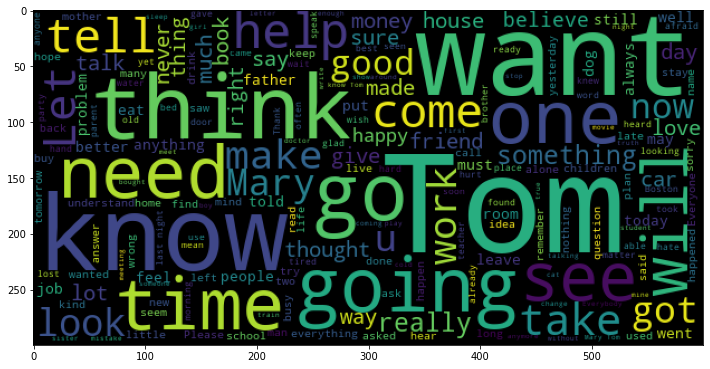

In [9]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

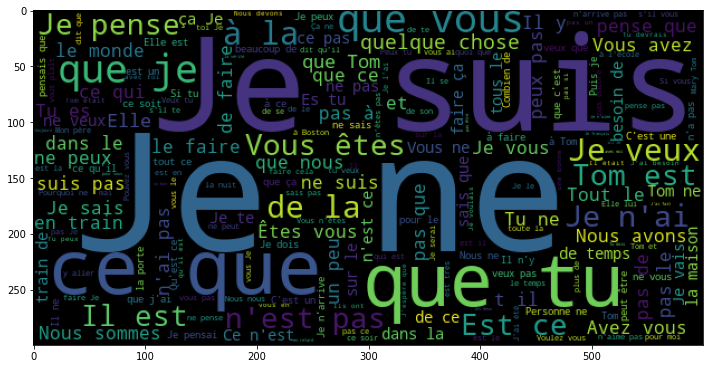

In [10]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(fra))
plt.imshow(wc)
plt.show();

In [11]:
def word_count(line):
  return len(line.split())

In [12]:
df['English_word_count'] = df['English words/sentences'].apply(lambda x: word_count(x))
df['French_word_count'] = df['French words/sentences'].apply(lambda x: word_count(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


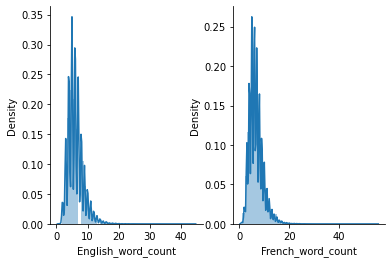

In [13]:
fig, axes = plt.subplots(nrows=1,ncols=2)
sns.distplot(df['English_word_count'],ax=axes[0])
sns.distplot(df['French_word_count'],ax=axes[1])
sns.despine()
plt.show();

In [14]:
def create_tokenizer(sentences):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  return tokenizer

In [15]:
def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

In [16]:
def encode_sequences(tokenizer,sentences,max_sent_len):
  text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
  text_pad_seq = pad_sequences(text_to_seq,maxlen=max_sent_len,padding='post') # pad sequences with 0
  return text_pad_seq

In [17]:
# Prepare English tokenizer
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_sent_len = max_sentence_length(eng)
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_eng_sent_len)

English vocabulary size: 14532
Maximum length of English sentences: 44


In [18]:
# Prepare French tokenizer
fra_tokenizer = create_tokenizer(fra)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_sent_len = max_sentence_length(fra)
print("French vocabulary size:", fra_vocab_size)
print("Maximum length of French sentences:", max_fra_sent_len)

French vocabulary size: 30661
Maximum length of French sentences: 55


In [19]:
max_eng_sent_len = 22
max_fra_sent_len = 22

In [20]:
# Perform encoding of sequences
X = encode_sequences(eng_tokenizer,eng,max_eng_sent_len)
y = encode_sequences(fra_tokenizer,fra,max_fra_sent_len)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)

In [ ]:
def create_model(src_vocab_size,dest_vocab_size,src_timesteps,dest_timesteps,no_units):
  model = Sequential()
  model.add(Embedding(src_vocab_size,no_units,input_length=src_timesteps,mask_zero=True))
  model.add(LSTM(no_units))
  model.add(RepeatVector(dest_timesteps))
  model.add(LSTM(no_units,return_sequences=True))
  model.add(TimeDistributed(Dense(1024,activation='relu')))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(dest_vocab_size,activation='softmax')))
  return model

In [ ]:
model = create_model(eng_vocab_size,fra_vocab_size,max_eng_sent_len,max_fra_sent_len,512)
model.summary()

2022-10-15 18:29:10.211736: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 512)           7440384   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 22, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 22, 512)           2099200   
_________________________________________________________________
time_distributed (TimeDistri (None, 22, 1024)          525312    
_________________________________________________________________
dropout (Dropout)            (None, 22, 1024)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 22, 30661)         3

In [ ]:
model.compile(loss=SparseCategoricalCrossentropy(),optimizer='rmsprop',metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_accuracy',patience=3,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [ ]:
r = model.fit(X_train,
              y_train.reshape(y_train.shape[0],y_train.shape[1],1),
              epochs=5,
              batch_size=512,
              callbacks=[es,lr],
              validation_data=(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1)))

2022-10-15 18:29:12.136483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
292/292 [==============================] - 7194s 25s/step - loss: 2.2671 - accuracy: 0.7101 - val_loss: 1.9164 - val_accuracy: 0.7258
Epoch 2/5
292/292 [==============================] - 7174s 25s/step - loss: 1.8247 - accuracy: 0.7364 - val_loss: 1.7141 - val_accuracy: 0.7458
Epoch 3/5
292/292 [==============================] - 7145s 24s/step - loss: 1.6407 - accuracy: 0.7538 - val_loss: 1.5947 - val_accuracy: 0.7579
Epoch 4/5
292/292 [==============================] - 7173s 25s/step - loss: 1.4883 - accuracy: 0.7661 - val_loss: 1.4618 - val_accuracy: 0.7703
Epoch 5/5
292/292 [==============================] - 7198s 25s/step - loss: 1.3643 - accuracy: 0.7759 - val_loss: 1.3724 - val_accuracy: 0.7761


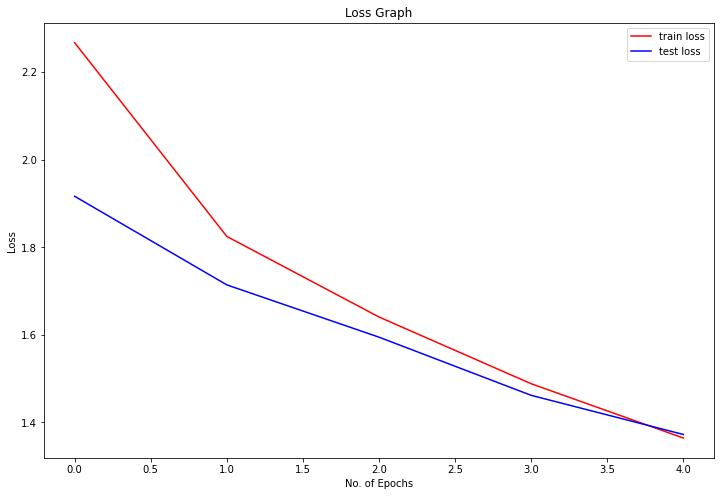

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

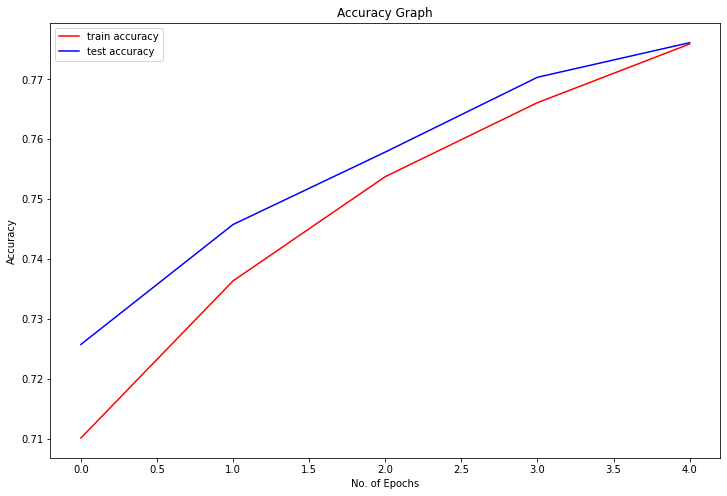

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

824/824 [==============================] - 509s 618ms/step - loss: 1.3724 - accuracy: 0.7761


[1.372438669204712, 0.7761004567146301]

In [ ]:
model.save('english_to_french_translator.h5')

In [33]:
translator_model = load_model('/content/drive/MyDrive/Datasets/english_to_french_translator.h5')
translator_model

In [55]:
sample_test, orig_fra_sent = X_test[:22], y_test[:22]
sample_test[:2], orig_fra_sent[:2]

(array([[   9,   45,    1,   21, 3601,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 190, 3332,    4,  326,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int32),
 array([[  63,   44,   34,   93, 6509,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 642, 4877,    9,  278,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int32))

In [56]:
test_predictions = translator_model.predict(sample_test)
test_predictions[:2]

1/1 [==============================] - 1s 858ms/step


array([[[1.12641783e-06, 4.66861157e-03, 1.54677718e-06, ...,
         5.24104182e-09, 3.49823215e-09, 2.83939205e-09],
        [4.66085505e-04, 1.14415959e-02, 1.11704830e-04, ...,
         1.09606844e-06, 1.53677649e-06, 1.09049870e-06],
        [1.03754376e-03, 3.29213403e-02, 7.19060539e-04, ...,
         1.65851498e-06, 2.33258606e-06, 1.59933450e-06],
        ...,
        [9.99999821e-01, 3.90634539e-11, 2.04987494e-08, ...,
         2.37260864e-16, 2.40304994e-16, 1.12078804e-16],
        [9.99999940e-01, 2.60989164e-11, 1.60606177e-08, ...,
         1.38174142e-16, 1.38880660e-16, 6.46698207e-17],
        [9.99999940e-01, 1.80233432e-11, 1.28688376e-08, ...,
         8.31001194e-17, 8.30050731e-17, 3.85362073e-17]],

       [[7.02911302e-06, 3.19662131e-03, 6.28820853e-04, ...,
         2.34412703e-08, 2.63800715e-08, 2.92113853e-08],
        [3.70044465e-04, 1.40390301e-03, 4.89015728e-01, ...,
         8.20361912e-09, 1.42580703e-08, 1.19848780e-08],
        [4.08048416e-03, 

In [72]:
def convert_pred_to_sent(input_seq):
    sent = ''
    for idx in input_seq:
      if idx:
        sent += fra_tokenizer.index_word[idx] + ' '
    sent = sent[:-1]
    return sent

In [73]:
def convert_idx_to_sent(input_seq,tokenizer):
    sent = ''
    for idx in input_seq:
      if idx:
        sent += tokenizer.index_word[idx] + ' '
    return sent

In [74]:
len(sample_test), len(orig_fra_sent), len(test_predictions)

(22, 22, 22)

In [78]:
orig_eng_text = []
orig_fra_text = []
pred_fra_text = []

for i in range(len(sample_test)):
  orig_eng_text.append(convert_idx_to_sent(sample_test[i],eng_tokenizer))
  pred_fra_text.append(convert_pred_to_sent(np.argmax(test_predictions[i],axis=1)))
  orig_fra_text.append(convert_idx_to_sent(orig_fra_sent[i],fra_tokenizer))

In [80]:
predictions = pd.DataFrame()
predictions['Original English Sentence'] = orig_eng_text
predictions['Original French Sentence'] = orig_fra_text
predictions['Predicted French Sentence'] = pred_fra_text  
predictions

,Original English Sentence,Original French Sentence,Predicted French Sentence
0,he and i are cousins,lui et moi sommes cousins,tom et moi sont
1,stop avoiding the question,arrête d'éviter la question,arrête de de ce
2,i'm a little confused,je suis un peu perplexe,je suis un peu peu
3,i'm just a teacher,je ne suis qu'un enseignant,je suis suis un
4,he went back home,il est revenu à la maison,il est allé à à
5,i want my dinner brought to my room,je veux que mon déjeuner soit apporté dans ma ...,je veux que ma ma ma ma ma ma
6,are they coming too,viennent ils aussi,sont sont
7,he adapted himself to his new life,il s'adapta à sa nouvelle vie,il se son son de vie
8,you're very brave,vous êtes très braves,vous êtes fort
9,i'm still your friend,je suis toujours ton amie,je suis suis ton ton
